# Exercise 1 - Eigenvalues, Eigenvectors, and Prototypes

In [4]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


from sklearn.preprocessing import normalize

import timeit
import functools

from scipy.spatial.distance import cdist
import numpy.random as rnd
import imageio as imageio

---
## Task 1.1

In [5]:
### load the data as a float-vector
matX = np.load('faceMatrix.npy').astype('float')
### interpret the float-vector as a mxn matrix and print these dimensions
m, n = matX.shape
print(m,n)

361 2429


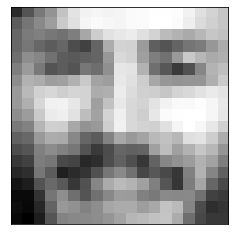

In [6]:
### re-interpret column 15 of this huge matrix 'matX' (lenght 361=19x19), 
### as a 19x19 matrix
vecX = matX[:,14].reshape(19,19)
def plot_matrix(M):
    plt.imshow(vecX, cmap='gray')
    plt.xticks([]) ### dont plot the x/y coordinates 1..18 (instead use [])
    plt.yticks([])
    plt.show

plot_matrix(vecX)

**1. Normalize the matrix**

In [7]:
def show_mat_blue(M, n=None):
    fig, ax = plt.subplots()
    if n is None:
        ax.matshow(M, cmap=plt.cm.Blues)
    else:
        ax.matshow(M.reshape(n, n), cmap=plt.cm.Blues)
    plt.xticks([]), plt.yticks([])
    plt.show()

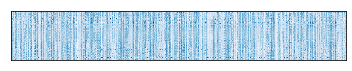

In [8]:
### Scale input vectors individually to unit norm
method1_normX = normalize(matX, axis=1, norm='l1')

show_mat_blue(method1_normX)

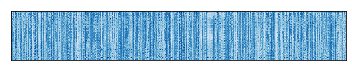

In [9]:
### Normalize data to zero mean
method2_normX = matX - np.mean(matX, axis=1).reshape(m,1)

show_mat_blue(method2_normX)
matX = method2_normX

In [10]:
np.array_equal(method1_normX, method2_normX)

False

**2. Compute $XX^T$**

There are different methods for matrix multiplication. For example:
- `matC_1 = np.matmul(matX, matX.transpose())`
- `matC_2 = np.dot(matX, matX.T)`
- `matC_3 = matX.dot(matX.T)`

But as suggested in the lecture, use the `@` operator:

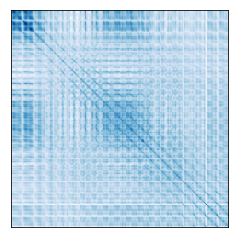

In [11]:
matC = matX @ matX.T
show_mat_blue(matC)

**3. Compute $C=U \Lambda U^T$ - la.eig**

In [12]:
eigenval_eig, eigenvec_eig = la.eig(matC)

**4. Compute $C=U \Lambda U^T$ - la.eigh**

In [13]:
eigenval_eigh, eigenvec_eigh = la.eigh(matC)

**5. Compare la.eig and la.eigh**

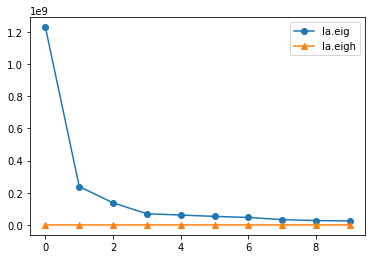

In [14]:
plt.plot(eigenval_eig[:10], marker='o', label='la.eig')
plt.plot(eigenval_eigh[:10], marker='^', label='la.eigh')
plt.legend()
plt.show()

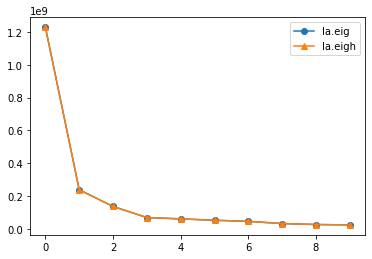

In [15]:
### reverse the order of eigenvalues computed using la.eigh
eigenval_eigh = eigenval_eigh[::-1]

plt.plot(eigenval_eig[:10], marker='o', label='la.eig')
plt.plot(eigenval_eigh[:10], marker='^', label='la.eigh')
plt.legend()
plt.show()

- `la.eig` does not give any guarantees on the order of the eigenvalues it returns
  - From documentation: "Compute the eigenvalues and right eigenvectors of _a square array_."
- `la.eigh`
  - From documentation: "Return the eigenvalues and eigenvectors of _a complex Hermitian (conjugate symmetric) or a real symmetric matrix"_
  - returns eigenvalues in _ascending_ order
- both methods return normalized eigenvectors

**6. Compute $X=U \Sigma V^T$ - la.svd**

In [16]:
np.seterr(all="print")
unitaries_U_svd, singularvals_svd, unitaries_Vt_svd = la.svd(matC)
eigenval_svd = singularvals_svd**2

**7. Square Eigenvalues**

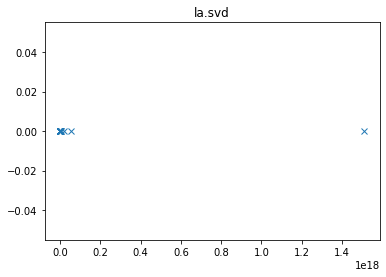

In [17]:
fig, ax = plt.subplots()
# ax.matshow(eigenval_svd.reshape(19,19), cmap=plt.cm.Blues)
# plt.xticks([]), plt.yticks([])
plt.title('la.svd')
plt.plot(eigenval_svd, np.zeros_like(eigenval_svd), 'x')

plt.show()

**8. Plot spectra**

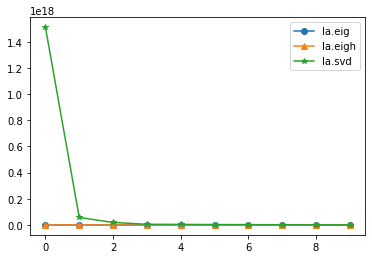

In [18]:
### plot the eigenvalues
plt.plot(eigenval_eig[:10], marker='o', label='la.eig')
plt.plot(eigenval_eigh[:10], marker='^', label='la.eigh')
plt.plot(eigenval_svd[:10], marker='*', label='la.svd')
plt.legend()
plt.show()

### Note the scale of the y-axis: 1e18 = 10**18
### Above it was: 1e9 = 10**9

---

## Task 1.2

In [19]:
### Define functions for time measurements
### For fairness: include the necessary computation of C
def PCA_eig(X):
    C = X @ X.T 
    l, U = la.eig(C)

def PCA_eigh(X):
    C = X @ X.T
    l, U = la.eigh(C)

def SVD(X):
    U, s, Vt = la.svd(X)

In [20]:
matX = np.load('faceMatrix.npy').astype('float')
m, n = matX.shape
matX = matX - np.mean(matX, axis=1).reshape(m,1)

In [21]:
# according to: https://www.researchgate.net/publication/329449786_NumPy_SciPy_Recipes_for_Image_Processing_Avoiding_for_Loops_over_Pixel_Coordinates
ts = timeit.Timer(functools.partial(PCA_eig, matX)).repeat(3, 100)
print (min(ts) / 100)

ts = timeit.Timer(functools.partial(PCA_eigh, matX)).repeat(3, 100)
print (min(ts) / 100)

ts = timeit.Timer(functools.partial(SVD, matX)).repeat(3, 100)
print (min(ts) / 100)

0.07503407011041417
0.016870934129692615
0.9912683660304173


The timeit-number (here '100') is the number of executions of the main statement.
= Return time it takes to execute the fct 100 times [sec, float]
The repeat-number (here '3') is the number of timeit-executions.
From python.org (https://docs.python.org/3/library/timeit.html):
Do not calculate mean and std.dev. Use the lowest value 
= lower bound for how fast your machine can run the given code snippet
Higher values are typically not caused by variability in Python’s speed, 
but by other processes interfering with your timing accuracy.

Here are runtimes (in seconds) measured on an Intel i5 (2.9 GHz) (outside a notebook)
    
- la.eig  : 0.03231685656995978
- la.eigh : 0.00624352695012930
- la.svd  : 0.14175234847993123

*Conclusion:* la.eigh is by far the fastest!

---

## Task 1.3

In [22]:
def qrAlgorithm(X, tmax=10):
    C = X @ X.T
    
    for _ in range(tmax):
        Q, R = la.qr(C)
        C = R @ Q

    return C

**Run the QR algorithm and print diagonal of resulting matrix $C$**

In [23]:
matX = np.load('faceMatrix.npy').astype('float')
m, n = matX.shape
matX = matX - np.mean(matX, axis=1).reshape(m,1)

In [24]:
matC = qrAlgorithm(matX)
# print (np.diag(matC))

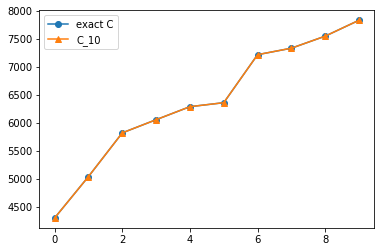

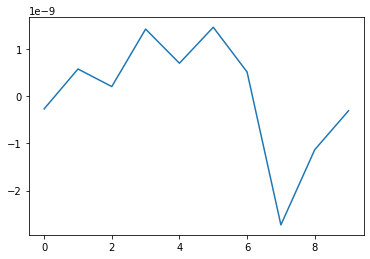

In [25]:
C = matX @ matX.T
eigenvals, U = la.eigh(C)
eigenvals_10, U_10 = la.eigh(matC)

difference = eigenvals - eigenvals_10

plt.plot(eigenvals[:10], marker='o', label='exact C')
plt.plot(eigenvals_10[:10], marker='^', label='C_10')
plt.legend()
plt.show()
plt.plot(difference[:10])
plt.show()

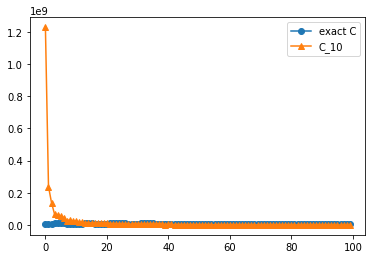

In [26]:
### Compating the diagonal entries
plt.plot(np.diag(C)[:100], marker='o', label='exact C')
plt.plot(np.diag(matC)[:100], marker='^', label='C_10')
plt.legend()
plt.show()

In [27]:
ts = timeit.Timer(functools.partial(qrAlgorithm, matX)).repeat(3, 100)
print(min(ts) / 100)

0.07185752887977287


Here are runtimes (in seconds) measured on an Intel i5 (2.9 GHz)

    QR-algorithm : 0.03119684626988601

*Conclusion:* the manually implemented QR algorithm is approximately as fast as la.eigh but the first diagonal entries are quite off.

**More formal:**
By defintion of $X$ we have:
$$ C= X^T X = U^T\Sigma VV^T \Sigma U = U^T\Sigma^2 U $$
and for the first itation it is:

$ C = C_0 = Q_1 R_1 = Q_1^T U^T \Sigma^2 U $

For iteration $t$ it is:

$ C_t = R_t Q_t = Q_t^T C_{t-1} Q_t = Q_t^T Q_{t-1}^T \dots Q_1^T U \Sigma^2 U Q_1 \dots Q_t $

Thus we get an upper triangular matrix

$ Q_t^T Q_{t-1}^T \dots Q_1^T U\Sigma^2 U Q_1\dots Q_{t-1} = R_t $

and similarly a lower triangular matrix

$ Q_{t-1}^T \dots Q_1^T U\Sigma^2 U Q_1\dots Q_{t-1} = R_t^T $

The definition of eigenvalues implies that the eigenvalues of $R_t$ are it’s diagonal entries. They have to be the same as the eigenvalues of $\Sigma^2$, since each $Q_i$ can be seen as an **exchange of basis** and $Q_i^T$ as the back conversion.

## Task 1.4

In [28]:
def kMaxOnline(X, k, numpasses=2):
    ### We prefer to have one image in one row (not column as before)
    X = X.T
    
    ### n = nr of rows = nr of images
    n, m = X.shape    
    
    ### Randomly permute the images
    inds = rnd.permutation(np.arange(n))
    X = X[inds]
    
    ### Get a copy of the first k rows/images (therefore the random shuffle)
    M = np.copy(X[:k]) # = np.copy(X[:k,])
    
    ### Now perform numpass iterations of optimization
    for t in range(numpasses):
        ### X[j] represents any other test-image, that may be 'far apart'
        for j in range(n):
            x = X[j]
            ### Compute the square distances from the test-image to all k selected
            D = np.sum((M - x)**2, axis=1)
            
            ### Get the position of the lowest distance (can most likely be improved)
            i = np.argmin(D)
            ### Compute the square distances from the image at position 'M[i]' to all k selected
            d = np.sum((M - M[i])**2, axis=1)
           
            D[i] = 0.
            d[i] = 0.
            valx = np.sum(D)
            valm = np.sum(d)
            
            ### If the distances 'D'/'valx' between all images with 'x'
            ### are greater than 'd'/'valm' between all images with 'M[i]' instead,
            ### replace 'M[i]' with the more distant 'x'
            if valx > valm:
                M[i] = x
    
    # bonus: compute accumulated intraset distance
    intrasetdist = cdist(M, M).sum()/2
#     print(f"intrasetdist for k={k}: {intrasetdist}")

    return M.T, intrasetdist

In [29]:
### Functions for a pretty display
def imageWrite(f, filename):
    imageio.imwrite(filename, f.astype('uint8'))

def arrangeOnGrid(X, nx, ny, w, h, bg, delta):
    """
        X: data matrix
        nx: int - number of rows
        ny: int - number of columns
        w: int - width of the images
        h: int - height of the images
        bg: int - color value for the background
        delta: int - offset between the images
    """
    dim, num = X.shape

    if w is None and h is None:
        w = int(np.sqrt(dim)) # small image width
        h = w                 # small image height

    # Initialize the image with needed size and pixel color 'bg'
    I = np.ones((ny*(delta+h), nx*(delta+w)), dtype=np.uint8) * bg
    
    # Iterate through 'X', read out and print the values and keep the offset 'delta'
    for i in range(ny):
        for j in range(nx):
            x = X[:,i*nx+j].reshape(h,w)

            ilow = i*(h+delta) + delta//2
            jlow = j*(w+delta) + delta//2
            ihgh = i*(h+delta) + delta//2 + h
            jhgh = j*(w+delta) + delta//2 + w

            I[ilow:ihgh,jlow:jhgh] = x

    return I


def showImages(X, nx, ny, fname, w=None, h=None, bg=255, delta=2):
    I = arrangeOnGrid(X, nx, ny, w, h, bg, delta)
    imageWrite(I, fname)

In [30]:
matX = np.load('faceMatrix.npy').astype('float')
m, n = matX.shape

In [31]:
### Compute the image-sets and store the constructed image
### and store the distances in 'dist' for the disyplaying afterwards
fnames, dists = [], []
for k in [4, 9, 16, 25, 49, 100]:
    matM, d = kMaxOnline(matX, k)
    dists += [d]
    ncol = int(np.sqrt(k))
    nrow = int(np.sqrt(k))
    fnames += [f't1-4-k{k}.png']
    showImages(matM, ncol, nrow, fname=fnames[-1])

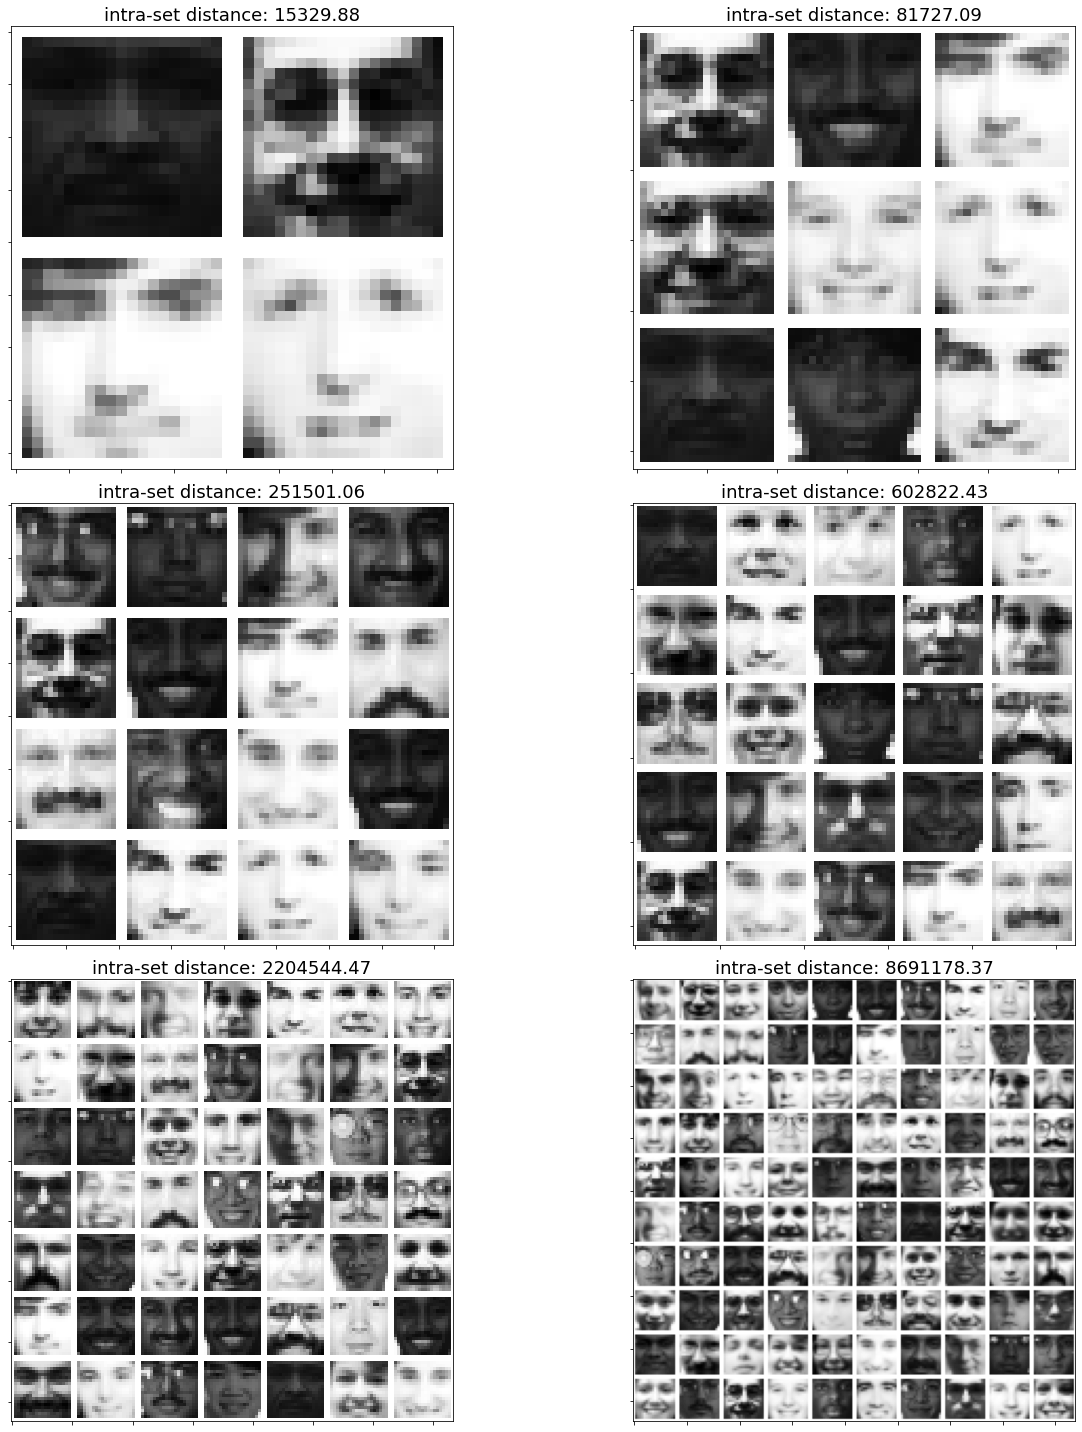

In [32]:
### Display the constructed images here
fig, axs = plt.subplots(int(0.5*len(fnames)), 2, figsize=(20,20))
for i, (f, d) in enumerate(zip(fnames, dists)):
    im = plt.imread(f)
    ax = axs[int(i/2), i%2]
    ax.imshow(im, cmap='gray');ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_title(f"intra-set distance: {d:.2f}", fontsize=18)
fig.tight_layout()

*Another idea:* 
Exploit that **clustering algorithms** such as k-Means not only select cluster centers that minimize intra-cluster variance, but at the same time also **maximize the inter-cluster variance**. From this point of view, the images closest to cluster centroids resulting from such an algorithm should present good candidates for $S^∗$.